# Final Project 
# **Advances in Data Sciences and Architecture**
## Name : **Rohan Kapadnis**
## NUID : **1342161**


---------------------------------------------------------------------------------------------------------------------

# Title : COVID-19 Mask Detector

## Aim of the Project : 

**The goal and objective of this project is to develop a face mask detector which would easily identify whether a person is wearing a mask or not. This will keep a check on people not wearing masks and in return will help ensure public safety.**

**The problem that I am trying to address is lack of awareness among people ofnot wearing a mask during the COVID pandemic. People who are not wearing masks should be banned from entering public spaces and this project aims at identifying the ones wearing a mask from the ones who are not.**

---------------------------------------------------------------------------------------------------------------------

<img src="https://d3lkc3n5th01x7.cloudfront.net/wp-content/uploads/2020/04/01023335/MaskDetection_Banner-1-1.png" alt="Alt text that describes the graphic" title="Face Mask Detector" />


## Dataset
To train a deep learning model to classify whether a person is wearing a mask or not,we need to find a good dataset with a fair amount of images for both classes:

1. wearing a mask

2. not wearing a mask

The **“Real World Masked Face Dataset(RMFD)”** that contains 5,000 masked faces of 525 people and 90,000 normal faces
Link to the dataset: https://github.com/X-zhangyang/Real-World-Masked-Face-Dataset

The team have created the world's largest masked face dataset to accumulate data resources for possible intelligent management and control of similar public safety events in the future.




---------------------------------------------------------------------------------------------------------------------

## Approach
**I will be using PyTorch which is an excellent deep learning framework with thousands of inbuilt functionalities that makes it a child’s play to create / train / test various models.**

---------------------------------------------------------------------------------------------------------------------

# Corresponding MEDIUM Article for this project 
I have published a Medium Aricle for this project. I would suggest reading this article to get a brief overview of this project! It includes all the necessary explanations and corresponding code. 

## Link : https://medium.com/@rohankapadnis/covid-19-mask-detector-b31bab72f569

# Steps : 

1. Data Extraction and Preparation 
2. PyTorch Dataset Creation 
3. Creating Dataloader
4. Dataloader creation for batching 
5. Defining the model 
6. Training the model
7. Results

## Importing dependencies

In [1]:
import torch 
import os
from pathlib import Path
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# Dataset Extraction and Preparation 

The RMFD dataset is divided in 2 parts. Masked Face dataset and Unmasked face dataset. 

In [2]:
classes = ['Non-Masked', 'Masked']

In [3]:
REBUILD_DATA = False

if REBUILD_DATA: #if we are running it for the first time
    data_path = Path('./Dataset/self-built-masked-face-recognition-dataset/')
    maskPath = data_path/'AFDB_masked_face_dataset'
    nonMaskPath = data_path/'AFDB_face_dataset'  
    maskDF = pd.DataFrame() 
    path_dirs = [ [maskPath,1],[nonMaskPath,0] ] #path and label
    if not os.path.exists(data_path):
        raise Exception("The data path doesn't exist")

The following code reads an image from disk with `cv2.imread(path)` and saves the resulting numpy.array in training_data variable

Once all the images have been read successfully, the numpy array is saved to disk with `np.save(path, variable)` it can be loaded easily with `np.load()` next time


In [4]:
class MaskvsNoMask():
    IMG_SIZE = 100
    LABELS = {'NON_MASKED': 0, 'MASKED': 1}
    training_data = []
    
    count = 0
    
    def make_training_data(self):
        for data_dir, label in path_dirs:
            print('Reading from: ',label)
            for folder in tqdm(os.listdir(data_dir)):
                folder_path = os.path.join(data_dir, folder)
                for imgpath in os.listdir(folder_path):
                    self.count += 1                       
                    img_path = os.path.join(folder_path, imgpath)
                    try:
                        img = cv2.imread(img_path)
                        img = cv2.resize(img, (self.IMG_SIZE,self.IMG_SIZE))
                        self.training_data.append([np.array(img), label])
                        self.count +=1
                        
                        if label == 1:
                            self.LABELS['MASKED'] += 1
                        if label == 0:
                            self.LABELS['NON_MASKED'] +=1
                            
                        if self.count > 10000:
                            self.count = 0
                            np.random.shuffle(self.training_data)
                            np.save("./npy/training_data.npy", self.training_data)
                            return
                    except:

                        pass
            print(self.LABELS)

        np.random.shuffle(self.training_data)
        np.save("./npy/training_data.npy", self.training_data)
        
if REBUILD_DATA:
    maskvsnomask = MaskvsNoMask()
    maskvsnomask.make_training_data()
    training_data = maskvsnomask.training_data
else:
    training_data = np.load('./npy/training_data.npy', allow_pickle=True)

In [5]:
training_data[10][0].shape

(100, 100, 3)

Masked


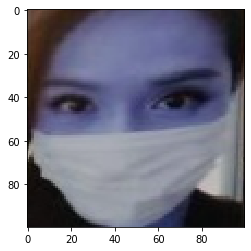

In [6]:
plt.imshow(training_data[4][0])
print(classes[training_data[1][1]])

# PyTorch dataset creation 

`torch.utils.data.Dataset` is an abstract class representing a dataset. The custom dataset should inherit `Dataset` and override the following methods:

`__len__` so that len(dataset) returns the size of the dataset.

`__getitem__` to support the indexing such that dataset[i] can be used to get \(i\)th sample


In [7]:
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor

In [8]:

class MaskDataset(Dataset):
        
        """ 
        0 = 'no mask'
        1 = 'mask'
        
        """
        
        def __init__(self, train_data):
            self.train_data = train_data
            self.transformations = Compose([
                ToTensor(), # [0, 1]
            ])
        
        def __getitem__(self, key):
            if isinstance(key, slice):
                raise NotImplementedError('slicing not supported')                    
            return [
                self.transformations(self.train_data[key][0]),
                torch.tensor(self.train_data[key][1]) 
            ]
        
        def __len__(self):
            return len(self.train_data)

In [9]:
myDataset = MaskDataset(training_data)

In [10]:
myDataset[5]

[tensor([[[0.0824, 0.0706, 0.0706,  ..., 1.0000, 1.0000, 1.0000],
          [0.0745, 0.0784, 0.0863,  ..., 1.0000, 1.0000, 0.9961],
          [0.0784, 0.0824, 0.0863,  ..., 0.9725, 1.0000, 1.0000],
          ...,
          [0.1647, 0.1686, 0.1686,  ..., 0.4667, 0.4706, 0.4784],
          [0.1804, 0.1804, 0.1804,  ..., 0.4471, 0.4549, 0.4667],
          [0.1961, 0.1961, 0.1922,  ..., 0.4353, 0.4471, 0.4588]],
 
         [[0.1216, 0.1098, 0.1098,  ..., 0.9961, 0.9961, 1.0000],
          [0.1137, 0.1176, 0.1216,  ..., 0.9961, 0.9922, 0.9765],
          [0.1176, 0.1216, 0.1216,  ..., 0.9608, 0.9961, 0.9961],
          ...,
          [0.2431, 0.2471, 0.2510,  ..., 0.5843, 0.5882, 0.5922],
          [0.2588, 0.2588, 0.2627,  ..., 0.5608, 0.5686, 0.5804],
          [0.2745, 0.2784, 0.2784,  ..., 0.5490, 0.5569, 0.5725]],
 
         [[0.1882, 0.1765, 0.1765,  ..., 0.9765, 0.9725, 0.9725],
          [0.1804, 0.1843, 0.1882,  ..., 0.9725, 0.9647, 0.9412],
          [0.1843, 0.1882, 0.1882,  ...,

In [11]:
def show_example(data):
    img, label = data
    print('Label: ', classes[int(label.item())], "("+str(label.item())+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  Masked (1)


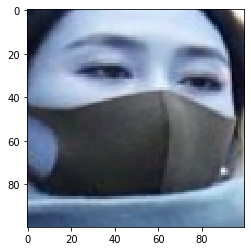

In [12]:
show_example(myDataset[5])

In [13]:
img, label = myDataset[1001]
print(img.shape)
print(label)

torch.Size([3, 100, 100])
tensor(1)


## Splitting the dataset in training and validation 

In [15]:
val_size = 1000
train_size = len(myDataset) - val_size

train_ds, val_ds = torch.utils.data.random_split(myDataset, [train_size, val_size])
len(train_ds), len(val_ds)

(3977, 1000)

Label:  Non-Masked (0)


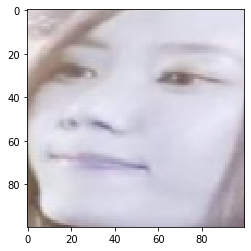

In [16]:
show_example(val_ds[77])

# DataLoader creation for Batching

Data Loading utility is the `torch.utils.data.DataLoader` class. It represents a Python iterable over a dataset
It supports : 
- map-style and iterable-style datasets
- customizing data loading order
- automatic batching
- single- and multi-process data loading

These options are configured by the constructor arguments of a `DataLoader`

`DataLoader` supports automatically collating individual fetched data samples into batches via arguments batch_size, drop_last, and batch_sampler.


In [17]:
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
batch_size = 32

In [18]:
train_dl = DataLoader(train_ds, batch_size*2, shuffle=True)
val_dl = DataLoader(val_ds, batch_size*2)

In [19]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

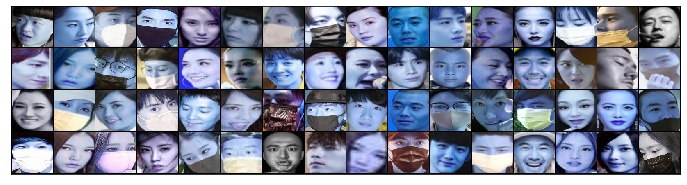

In [20]:
show_batch(val_dl)

# Defining the Model (Convolutional Neural Network)

To define the model I am using PyTorch built in `nn.module` class.

The `Conv2d` layer transforms a 3-channel image to a 16-channel feature map, and the `MaxPool2d` layer halves the height and width. The feature map gets smaller as we add more layers until we are finally left with a small feature map, which can be flattened into a vector. We can then add some fully connected layers at the end to get a vector of size 10 for each image.

In [21]:
input_size = 100*100
output_size = 2

In [22]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

#### Training loop
- training_step()
- Validation loop()
- validation_step()
- validation_epoch_end()

In [23]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels.long()) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels.long())   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [24]:
class MaskDetection(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 100, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(100, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(160000, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 2))
        
    def forward(self, xb):
        return self.network(xb)

#### PyTorch Cuda adds support for CUDA tensor types, that implement the same function as CPU tensors, but they utilize GPUs for computation

To seamlessly use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU as required

PyTorch normally runs on CPU, you can transfer any variable to GPU by simply doing a variable.to(‘cuda’)

In [26]:
torch.cuda.is_available()

True

In [27]:
def get_default_device():
    #Pick GPU if available, else CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    

In [28]:
device = get_default_device()
device

device(type='cuda')

In [29]:
def to_device(data, device):
    #Move tensor to chosen device
    
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [30]:
for images, labels in train_dl:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([64, 3, 100, 100])
cuda:0


In [31]:
class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        #Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        #Number of batches
        return len(self.dl)

In [34]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [35]:
for xb, yb in val_dl:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')


# Training the model 

I have used `nn.Sequential` to chain the layers and activations functions into single network architecture.


In [36]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    for epoch in range(epochs):
        # Training Phase 
        print('epoch: ', epoch)
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [32]:
# Model (on GPU)
model = MaskDetection()
to_device(model, device)


MaskDetection(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten()
    (11): Linear(in_features=160000, out_features=512, bias=True)
    (12): ReLU()
    (13): Linear(in_features=512, out_features=256, bias=True)
    (14): ReLU()
    (15): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [33]:
model.load_state_dict(torch.load('./MaskDetection.pth'))
model.eval()


MaskDetection(
  (network): Sequential(
    (0): Conv2d(3, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(100, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten()
    (11): Linear(in_features=160000, out_features=512, bias=True)
    (12): ReLU()
    (13): Linear(in_features=512, out_features=256, bias=True)
    (14): ReLU()
    (15): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [34]:
sum(p.numel() for p in model.parameters())

83055730

In [45]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 0.08930961787700653, 'val_acc': 0.9710937738418579}]

# Training Results 

In [55]:
history = fit(5, 1e-3, model, train_dl, val_dl)

epoch:  0
Epoch [0], train_loss: 0.6871, val_loss: 0.6796, val_acc: 0.5934
epoch:  1
Epoch [1], train_loss: 0.6811, val_loss: 0.6725, val_acc: 0.5934
epoch:  2
Epoch [2], train_loss: 0.6761, val_loss: 0.6622, val_acc: 0.5934
epoch:  3
Epoch [3], train_loss: 0.6613, val_loss: 0.6325, val_acc: 0.6342
epoch:  4
Epoch [4], train_loss: 0.6089, val_loss: 0.5455, val_acc: 0.7857


In [56]:
history = fit(10, 1e-3, model, train_dl, val_dl)

epoch:  0
Epoch [0], train_loss: 0.5185, val_loss: 0.3942, val_acc: 0.8445
epoch:  1
Epoch [1], train_loss: 0.2778, val_loss: 0.1896, val_acc: 0.9387
epoch:  2
Epoch [2], train_loss: 0.1700, val_loss: 0.1593, val_acc: 0.9455
epoch:  3
Epoch [3], train_loss: 0.1476, val_loss: 0.1635, val_acc: 0.9400
epoch:  4
Epoch [4], train_loss: 0.1329, val_loss: 0.1460, val_acc: 0.9496
epoch:  5
Epoch [5], train_loss: 0.1217, val_loss: 0.1199, val_acc: 0.9604
epoch:  6
Epoch [6], train_loss: 0.1136, val_loss: 0.1373, val_acc: 0.9449
epoch:  7
Epoch [7], train_loss: 0.1352, val_loss: 0.2133, val_acc: 0.9213
epoch:  8
Epoch [8], train_loss: 0.1076, val_loss: 0.1073, val_acc: 0.9643
epoch:  9
Epoch [9], train_loss: 0.0968, val_loss: 0.1124, val_acc: 0.9602


In [57]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [58]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

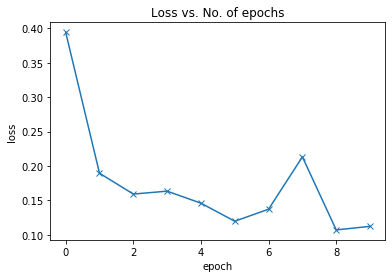

In [59]:
plot_losses(history)

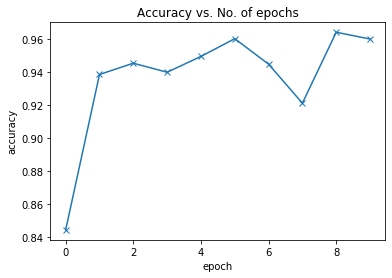

In [60]:
plot_accuracies(history)

The model reaches an accuracy of around 96.02%, and by looking at the graph, it seems unlikely that the model will achieve an accuracy higher than 99% even after training for a long time. 

This suggests that we might need to use a more powerful model to capture the relationship between the images and the labels more accurately. This can be done by adding more convolutional layers to our model, or increasing the number of channels in each convolutional layer, or by using regularization techniques.


The model was able to achieve an accuracy of 96.02 with only 8 epochs which is quite remarkable

## Saving the model to disk

In [61]:
torch.save(model.state_dict(), './model/MaskDetection.pth')

# Testing the model with Images

In [67]:
import matplotlib.image as mpimg
def singleImage(path, label= None, show= False):
    img = cv2.imread(path)
    assert img is not None,"Image not read properly"
    img = cv2.resize(img, (100, 100))
    img = torch.from_numpy(img)
    img = img.permute((2, 0,1)) # model expects image to be of shape [3, 100, 100]
    img = img.unsqueeze(dim=0).float() # convert single image to batch [1, 3, 100, 100]
    img = img.to('cuda') # Using the same device as the model
    pred = model(img)
    _, preds = torch.max(pred, dim=1)
    print(classes[preds.item()])
    
    if show:
        plt.imshow(mpimg.imread(path))
        print("the image is :" + classes[preds.item()])

In [68]:
def valImage(key, show = True):
    img = val_ds[key][0]
    pred = model(img.unsqueeze(dim=0).to(device))
    _, preds = torch.max(pred, dim=1)
    cv2.imshow('',img.permute(1, 2,0), cmap=cm.bgr)
    print("predicted:",classes[preds.item()])
    print("Actual:",classes[val_ds[key][1]])    

Masked
the image is :Masked


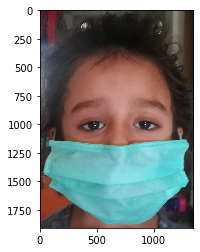

In [70]:
singleImage('./test_images/test23_masked.jpg', show=True)

# Conclusion 
The model could achieve accuracy of 96% and can be very well used for building a face detector application  which would easily identify whether a person is wearing a mask or not. This will keep a check on people not wearing masks and in return will help in ensuring public safety especially during the pandemic. 


# Citation

1. PyTorch for Deep Learning Course : https://www.youtube.com/watch?v=GIsg-ZUy0MY&t=19551s&ab_channel=freeCodeCamp.org

2. https://towardsdatascience.com/how-i-built-a-face-mask-detector-for-covid-19-using-pytorch-lightning-67eb3752fd61

3. PyTorch tutorial : https://pytorch.org/tutorials/


# Licensing 

Copyright 2020 Rohan Kapadnis

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.